### librerias2

In [19]:
import matplotlib
matplotlib.use('TkAgg')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
%matplotlib inline
plt.rcParams['figure.figsize']=(8,2)
plt.style.use('ggplot')

# Base de Datos

In [20]:
datos = pd.read_csv('datos_depurados.csv')

df = pd.DataFrame(datos)
df.City = df.City.astype('category')
df.type = df.type.astype('category')
df2 = df.iloc[:, [2, 3, 4, 5, 6, 7,8]]
df2.head()

,adjustSquareMeterPrice,finalACMPrice,originalPrice,area,bathrooms,rooms,garages
0,2.591867e+06,1.917364e+08,195000000,1115.0,2.0,3.0,2.0
1,4.310643e+06,4.687536e+08,460000000,300.0,2.0,3.0,0.0
2,4.830501e+06,5.492026e+08,560000000,300.0,2.0,3.0,0.0
3,3.304656e+06,6.503699e+08,668000000,300.0,2.0,3.0,0.0
4,3.758590e+06,2.854634e+08,360000000,300.0,1.0,3.0,0.0


## Normalizar Datos:

In [21]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

df_mean_norm = mean_norm(df2)
df_mean_norm.head()

,adjustSquareMeterPrice,finalACMPrice,originalPrice,area,bathrooms,rooms,garages
0,-0.929513,-0.505451,-0.505515,19.031307,-0.071485,-0.021542,1.856816
1,0.721815,1.450207,0.861735,3.993587,-0.071485,-0.021542,-0.785228
2,1.221273,2.018152,1.377678,3.993587,-0.071485,-0.021542,-0.785228
3,-0.244695,2.732363,1.934897,3.993587,-0.071485,-0.021542,-0.785228
4,0.191426,0.156233,0.345792,3.993587,-1.226005,-0.021542,-0.785228


# Análisis de Componentes Principales (PCA)

## Encontrar número de dimensiones:

Text(0.5, 1.0, 'Eibow curve')

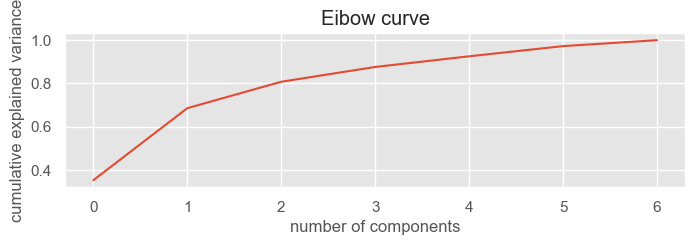

In [22]:
pca = PCA(n_components=7)
pca.fit(df_mean_norm)
x_pca = pca.transform(df_mean_norm)
expl = pca.explained_variance_ratio_

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Eibow curve')

## Realizar PCA con 3 dimensiones:

In [23]:
pca2 = PCA(n_components=3)
pca2.fit(df_mean_norm)
pca2.transform(df_mean_norm)

array([[11.29784031,  0.01221347,  0.34960099],
       [ 1.70718823,  1.95208258, -0.89002187],
       [ 1.62798922,  2.86405512, -0.89808667],
       ...,
       [-0.62912226,  1.13695124, -0.63308168],
       [-0.76655444,  2.81668406, -0.62522051],
       [-0.53461599,  0.09522933, -0.61321695]])

# K-MEANS

## Encontrar numero de cluster:

Text(0.5, 1.0, 'K-means with PCA Clustering')

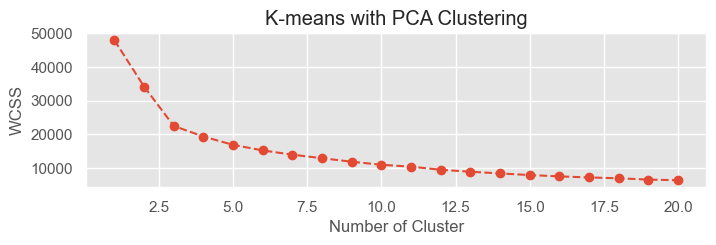

In [24]:
scores_pca = pca2.transform(df_mean_norm)
wcss = []

for i in range(1, 21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(8, 2))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')

## Implementar K-means:

In [25]:
k_means_pca2 = KMeans(n_clusters=5,init='k-means++',random_state=42)
k_means_pca2.fit(scores_pca)


KMeans(n_clusters=5, random_state=42)

## Análisis de Resultados:

Text(0.5, 1.0, 'Clusters by PCA Components')

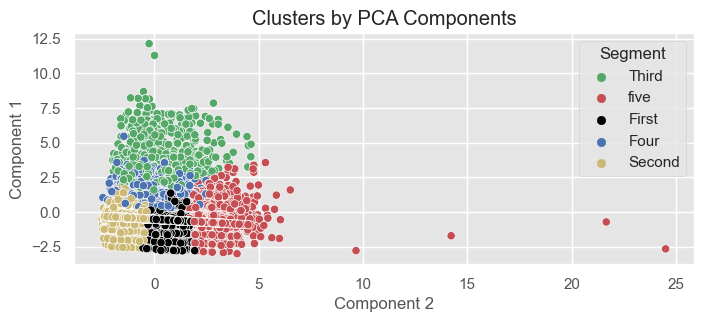

In [26]:
# Eiquetar componentes

df_segm_pca_kmeans = pd.concat([df_mean_norm.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']

# The last Column we add contains the pca K-means clustering labels

df_segm_pca_kmeans['Segment K-means PCA'] = k_means_pca2.labels_
df_segm_pca_kmeans['Segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0: 'First',
                                                                               1: 'Second',
                                                                               2: 'Third',
                                                                               3: 'Four',
                                                                               4:'five'})

plt.figure(figsize=(8,3))
sns.scatterplot(x=df_segm_pca_kmeans['Component 2'], y=df_segm_pca_kmeans['Component 1'], hue=df_segm_pca_kmeans['Segment'], palette=['g', 'r','#000000','b','y'])
plt.title('Clusters by PCA Components')

#### Contar observaciones por cluster:

In [27]:
labels = k_means_pca2.predict(scores_pca)
# Getting the cluster centers
C = k_means_pca2.cluster_centers_
colores = ['g', 'r','#000000','b','y']
asignar = []
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(scores_pca[:, 0], scores_pca[:, 1], scores_pca[:, 2], c=asignar, s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)


copy = pd.DataFrame()
copy['City']= datos['City'].values
copy['label'] = labels
cantidadGrupo = pd.DataFrame()
cantidadGrupo['color']= colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,g,2332
1,r,3530
2,#000000,572
3,b,998
4,y,1047


<Figure size 800x200 with 0 Axes>

#### Mirar observaciones de algun cluster por alguna variable:

In [28]:
group_referrer_index = copy['label'] == 2
group_referrals = copy[group_referrer_index]

diversidadGrupo = pd.DataFrame()
diversidadGrupo['City'] = ['Bogotá','Medellín']
diversidadGrupo['Cantidad'] = group_referrals.groupby('City').size()
group_referrals.groupby('City').size()

City
Bogotá      462
Medellín    110
dtype: int64

#### Inmuebles mas cercanos a los centroides:

In [29]:
#Posicion en el array de los inmuebles
closest,_= pairwise_distances_argmin_min(k_means_pca2.cluster_centers_,scores_pca)

#Numero de inmuebles
inmuebles= datos['Unnamed: 0'].values

for row in closest:
    print(inmuebles[row])

774
4814
3794
291
5866


#### Clasificar nuevos inmuebles:

In [30]:
x_new=np.array([[1.71,1.95,-0.89]])
new_labels2= k_means_pca2.predict(x_new)

new_labels2

array([4])

In [31]:
cluster=df_segm_pca_kmeans['Segment']
cluster=pd.DataFrame(cluster)

In [32]:
acp=pca2.transform(df_mean_norm)
acp=pd.DataFrame(acp)
acp

,0,1,2
0,11.297840,0.012213,0.349601
1,1.707188,1.952083,-0.890022
2,1.627989,2.864055,-0.898087
3,1.635795,2.823549,-0.885940
4,1.185553,0.530931,-0.874081
...,...,...,...
8474,-0.467727,-0.659023,-0.603457
8475,-0.480763,-0.516759,-0.606493
8476,-0.629122,1.136951,-0.633082
8477,-0.766554,2.816684,-0.625221


In [33]:
df_final=pd.concat([df,cluster,acp],axis=1)
df_final=df_final.iloc[:,1:]
df_final=df_final.rename({0:'Comp 1',1:'Comp 2',2:'Comp 3'},axis=1)
df_final

,id,adjustSquareMeterPrice,finalACMPrice,originalPrice,area,bathrooms,rooms,garages,type,City,location,Segment,Comp 1,Comp 2,Comp 3
0,874,2.591867e+06,1.917364e+08,195000000,1115.0,2.0,3.0,2.0,APA,Medellín,POINT (-75.6356756 6.1266824),Third,11.297840,0.012213,0.349601
1,33968,4.310643e+06,4.687536e+08,460000000,300.0,2.0,3.0,0.0,APA,Medellín,POINT (6.1435762684699 -75.616954237261),five,1.707188,1.952083,-0.890022
2,33535,4.830501e+06,5.492026e+08,560000000,300.0,2.0,3.0,0.0,APA,Medellín,POINT (6.1798535721365 -75.586581230164),five,1.627989,2.864055,-0.898087
3,33522,3.304656e+06,6.503699e+08,668000000,300.0,2.0,3.0,0.0,CAS,Medellín,POINT (4.8687603369878 -74.061080472327),five,1.635795,2.823549,-0.885940
4,31178,3.758590e+06,2.854634e+08,360000000,300.0,1.0,3.0,0.0,CCR,Medellín,POINT (6.21812 -75.604164),First,1.185553,0.530931,-0.874081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474,589,3.061488e+06,2.188737e+08,240000000,67.0,2.0,3.0,0.0,NaN,Bogotá,POINT (-75.56715130806 6.3204597576276),Second,-0.467727,-0.659023,-0.603457
8475,588,3.388656e+06,2.157647e+08,235000000,67.0,2.0,3.0,0.0,NaN,Bogotá,POINT (-75.640155473016 6.1512008335329),Second,-0.480763,-0.516759,-0.606493
8476,584,6.081246e+06,2.570061e+08,260000000,67.0,2.0,3.0,0.0,NaN,Bogotá,POINT (-74.0643515 4.6408836),First,-0.629122,1.136951,-0.633082
8477,582,4.041076e+06,6.062614e+08,680000000,67.0,2.0,3.0,0.0,NaN,Bogotá,POINT (-75.627654484587 6.156958424577),five,-0.766554,2.816684,-0.625221


In [34]:
df_final.to_csv('datos_shape.csv')